## Modifying Notebook display

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    .container#notebook-container    { width: 95%;}
    div#menubar-container     { width: 95%; }
    div#maintoolbar-container { width: 95%; }
</style>
<script>
    document.getElementById("notebook-container").style.margin = "auto";
</script>
"""))

## For running the notebook as Google Colab Instance

#mounting the google drive for accessing other necessary files
from google.colab import drive
drive.mount('/content/gdrive')

#Checking the available files in the "Colab Notebooks" folder of the google drive
!ls /content/gdrive/My\ Drive/Colab\ Notebooks

import sys

#changing the current working directory to "Colab Notebooks" folder in the google drive
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

## For running the notebook as Kaggle Kernel

change directory to the dataset where our custom scripts are uploaded

> ``os.chdir("/kaggle/input/handwritten-digit-recognition")``

***handwritten-digit-recognition*** is simply a folder name. It can vary based on the dataset you create in kaggle while uploading the python scripts.


load custom module or files or dataset

> ``from  dataset import load_dataset, train_dev_split, prep_dataset`` <br>
> ```from dataset import visualize_data_distribution, visualize_dataset```


reset our working directory

> ```os.chdir("/kaggle/working/")```

**NOTE:** The ***input directory*** is Read-Only. So, we must switch back to the ***working directory*** for performing any other operation that requires write access. Make sure this note book runs as a part of the dataset you create as said above because all the custom modules are uploaded there. 


## Importing Dependencies

In [2]:
import time    #for calculating time
import os
import gc
#core packages
import numpy as np
import matplotlib.pyplot as plt

# os.chdir("/kaggle/input/handwritten-digit-recognition")

#custom module
from dataset import load_dataset, train_dev_split, prep_dataset
from dataset import visualize_data_distribution, visualize_dataset

from ModelUtils import relu, relu_grad, softmax
from ModelUtils import rand_mini_batches, convert_time
from ModelUtils import confusion_matrix, plot_confusion_matrix, model_metrics, metric_summary
from ModelUtils import visualize_training_results, visualize_prediction, visualize_mislabelled_images
from ModelUtils import save_model, load_model

from dataAugmentation import data_generator,load_augmented_data

from ffnn import *


np.random.seed(5798)
%matplotlib inline

## Dataset Preparation

### Loading Dataset

In [3]:
dataset_size_in_per = 25

train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

print("Sample Size : %d%%\n"%(dataset_size_in_per))
print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")



Sample Size : 25%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (15000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (15000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (2500, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (2500, 1)


### Train-Dev set Split

In [4]:
train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x_orig, train_y_orig)

print("Data\t\t\t\t","Datatype\t\t","Shape")
print("========================================================================")
print("Training Set Images:\t\t" + str(type(train_x_split))+"\t",str(train_x_split.shape))
print("Training Set Labels:\t\t" + str(type(train_y_split))+"\t",str(train_y_split.shape))
print("Development Set Images:\t\t" + str(type(dev_x_split))+"\t",str(dev_x_split.shape))
print("Development Set Labels:\t\t" + str(type(dev_y_split))+"\t",str(dev_y_split.shape))
print("========================================================================")


Data				 Datatype		 Shape
Training Set Images:		<class 'numpy.ndarray'>	 (12750, 28, 28)
Training Set Labels:		<class 'numpy.ndarray'>	 (12750, 1)
Development Set Images:		<class 'numpy.ndarray'>	 (2250, 28, 28)
Development Set Labels:		<class 'numpy.ndarray'>	 (2250, 1)


### Visualizing Data Distribution

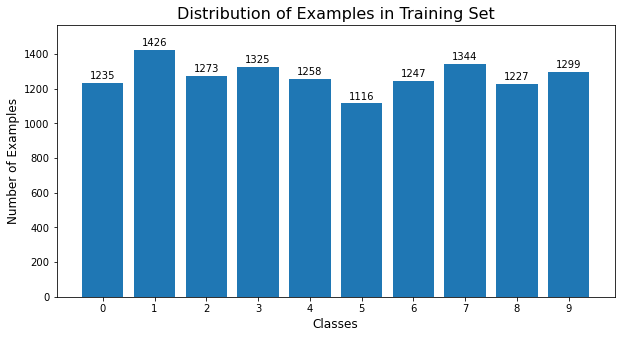

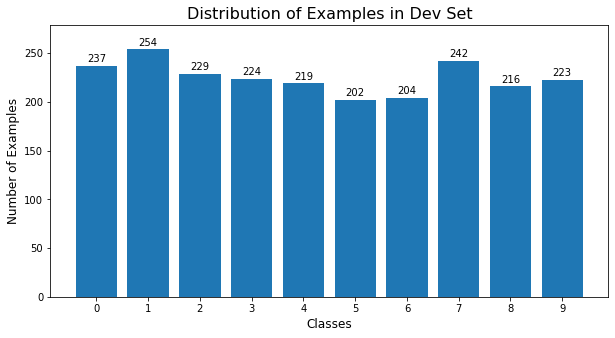

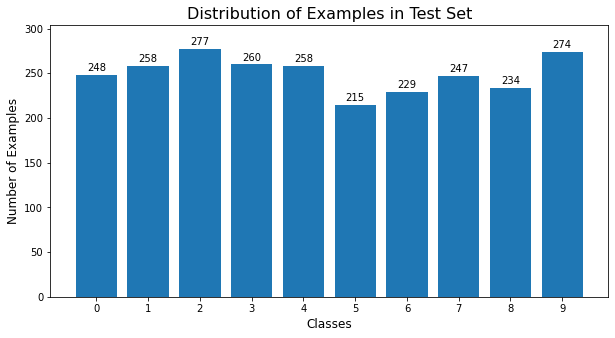

In [5]:
visualize_data_distribution(train_y_split, dataset_type = "training")
visualize_data_distribution(dev_y_split,  dataset_type = "dev")
visualize_data_distribution(test_y_orig,  dataset_type = "test")

### Visualizing Dataset

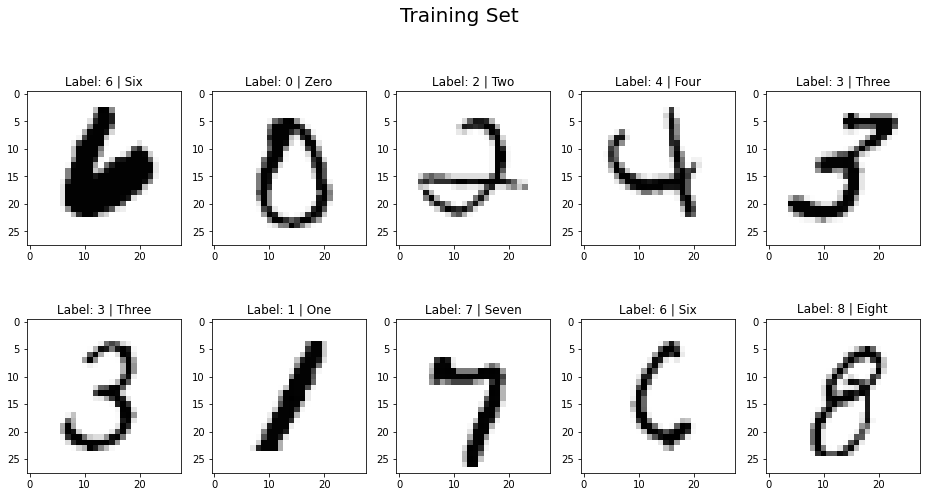

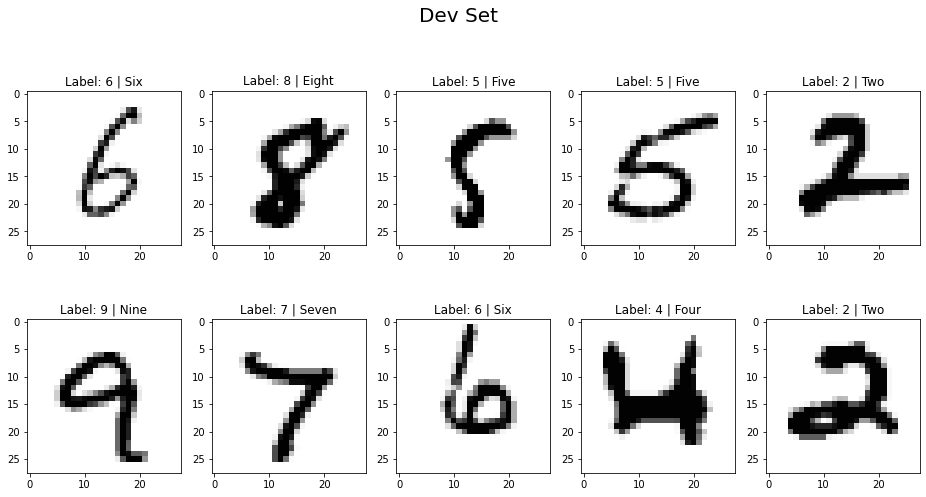

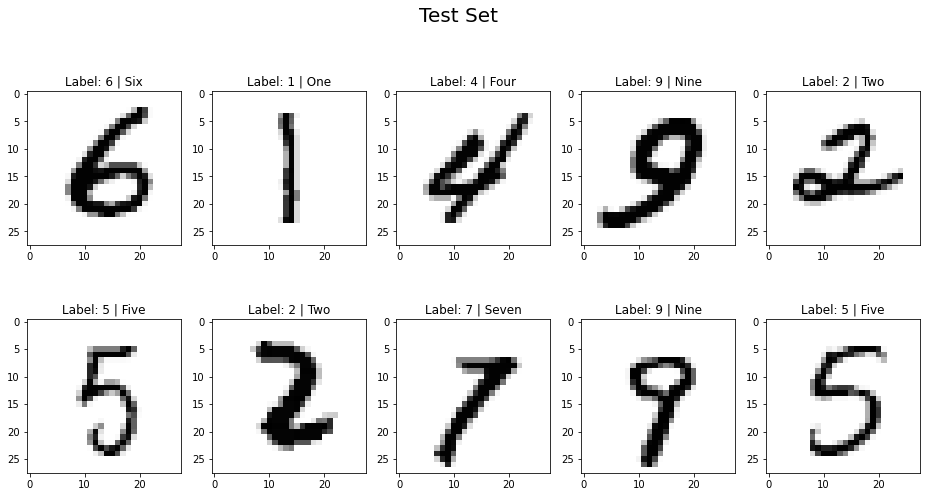

In [6]:
visualize_dataset(train_x_split, train_y_split, dataset = "mnist", dataset_type = "training")
visualize_dataset(dev_x_split, dev_y_split, dataset = "mnist", dataset_type = "dev")
visualize_dataset(test_x_orig, test_y_orig, dataset = "mnist", dataset_type="test")

### Preparing Dataset

The preprocess training set will only be used later during prediction. The splitted training set will be directly fed to the model and it is preprocessed in the fly during the augmentation process.

In [7]:
train_x_norm, train_y_encoded = prep_dataset(train_x_split, train_y_split, num_class = 10)
dev_x_norm, dev_y_encoded= prep_dataset(dev_x_split, dev_y_split, num_class = 10)
test_x_norm, test_y_encoded = prep_dataset(test_x_orig, test_y_orig, num_class = 10)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")


Data			 Before Processing	 After Processing
Training Set Images:	(12750, 28, 28)		(784, 12750)
Training Set Labels:	(12750, 1)		(10, 12750)
Dev Set Images:		(2250, 28, 28)		(784, 2250)
Dev Set Labels:		(2250, 1)		(10, 2250)
Test Set Images:	(2500, 28, 28)		(784, 2500)
Test Set Labels:	(2500, 1)		(10, 2500)


### Train Model

In [8]:
# Final Model Training
def train(training_data, validation_data , layers_dim, hyperParams, initialization = "random", optimizer = 'bgd',regularizer = None, verbose = 3, patience = None, step_decay = None):
    # unpacking the hyperparameters
    learning_rate = hyperParams['learning_rate']
    num_epoch = hyperParams['num_epoch']
    b1 = hyperParams['beta1']
    b2 = hyperParams['beta2']
    ep = hyperParams['epsilon']
    lambd = hyperParams['lambda']
    keep_probs = hyperParams['keep_probs']
    
    # unpacking the data
    X_train, Y_train = training_data
    X_dev,Y_dev = validation_data

    # setting up necessary variables for early stopping
    if patience != None and patience !=0:
        # configuring path to save the intermediate best parameters
        path = "temp/" 
        if not os.path.exists(path):
            os.makedirs(path) 
        filename = "best_param_intermediate"

        early_stop_count = 0 # count variable for counting consucative the epochs without progress
        max_val_acc = 0 # for keeping track of maximum validation accuracy
    
    #initializing the training variables
    seed = 1
    m = Y_train.shape[1]
    train_accs = []  # for keeping track of training accuracy
    val_accs = []     # for keeping track of Validation accuracy
    train_losses = []  # for keeping track of training loss
    val_losses = []     # for keeping track of Validation loss
    
    #selecting the minibatch size for each optimizer
    if optimizer == 'sgd':
        mini_batch_size = 1
    elif optimizer == 'bgd':
        mini_batch_size = m
    elif optimizer == 'mgd' or optimizer == 'adam':
        mini_batch_size = hyperParams['mini_batch_size']
    else:
        raise ValueError("Optimizer value out of scope")
        
    #initializing the model parameters
    parameters = init_parameters(layers_dim, initialization)
    
    #initializing adam parameters, used only when optimizer = 'adam'
    t = 0
    v,s = initialize_adam(parameters)
    
    train_tic = time.time() # for calculating entire training time
    print("Training The Model...")
    
    #Gradient Descent begins
    for i in range(num_epoch):
        seed += 1
        time_trained = 0 # for computing training time of each epoch
        batch_times = [] # for accumulating the training time of each batch
        accs = [] # for tracking batch training accuracy
        losses = [] # for tracking batch training loss
        
        #learning rate scheduling
        if step_decay!= None and step_decay!= 0:
            if i%step_decay == 0:
                decay_rate = learning_rate / ((i+1)/num_epoch)
                learning_rate = learning_rate_scledule(learning_rate, i, decay_rate)
                if learning_rate <= 0.0001: learning_rate = 0.0001 
        
           
        if verbose > 0:
            if step_decay!= None and step_decay!= 0:
                print("\nEpoch %d/%d: learning rate - %.6f"%(i+1,num_epoch,learning_rate))
            else:
                print("\nEpoch %d/%d"%(i+1,num_epoch))
        
        #augmenting the dataset online
        data_generator(X_train, Y_train, batch_size = 2048, aug_count = 1, pre_process_data = True)
        aug_images,aug_labels = load_augmented_data()
        
        #generating minibatches of the augmented dataset
        minibatches = rand_mini_batches(aug_images, aug_labels, mini_batch_size, seed)
        total_minibatches = len(minibatches)
        
        del aug_images,aug_labels
        
        for ind, minibatch in enumerate(minibatches):
            batch_tic = time.time() # for calculating time of an epoch cycle
            
            #retriving minibatch of X and Y from training set
            (minibatch_X, minibatch_Y) = minibatch
            
            #forward Propagation
            AL, caches, dropout_masks = forward_prop(minibatch_X, parameters, keep_probs = keep_probs, regularizer = regularizer)
            
            #Computing cross entropy cost
            cross_entropy_cost = softmax_cross_entropy_cost(AL, minibatch_Y, caches, lambd = lambd, regularizer = regularizer, from_logits = True) #accumulating the batch costs
            
            #Backward Propagation
            grads = backward_prop(AL, minibatch_Y, caches, dropout_masks = dropout_masks, keep_probs = keep_probs, lambd = lambd, regularizer = regularizer)
                
            #Updating parameters
            t += 1
            parameters, v, s = update_parameters(parameters, grads, learning_rate, optimizer = optimizer, beta1 = b1, beta2 = b2,  epsilon = ep, v = v, s = s, t = t)
            
            # Calculating training time for each batch 
            batch_times.append(time.time() - batch_tic)
            time_trained = np.sum(batch_times)
            
            #calculating training progress
            per = ((ind+1) / total_minibatches) * 100
            inc = int(per // 10) * 2
            
            #calculating accuracy and loss of the training batch
            acc,loss = evaluate(minibatch_X, minibatch_Y, parameters)
            accs.append(acc)
            losses.append(loss)
            
            
            #Verbosity 0: Silent mode
            #Verbosity 1: Epoch mode
            #Verbosity 2: Progress bar mode
            #Verbosity 3 or greater: Metric mode
                
            if verbose == 2:
                print ("%d/%d [%s>%s %.0f%%] - %.2fs"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_trained),end='\r')
            elif verbose > 2:
                print ("%d/%d [%s>%s %.0f%%] - %.2fs | loss: %.4f | acc: %.4f"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_trained, np.mean(losses), np.mean(accs)),end='\r')
            
            del caches,minibatch_X, minibatch_Y,minibatch,grads #clearing caches
        #----------------------------------------------batch ends-------------------------------------------

        #accumulating the acc and loss of the last iteration of each epoch
        train_accs.append(np.mean(accs))
        train_losses.append(np.mean(losses))
                
        #evaluating the model using validation accuracy and loss
        val_acc, val_loss= evaluate(X_dev, Y_dev, parameters)  
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        
       
        time_per_batch = int(np.mean(batch_times)*1000)

        if verbose == 2:
            print ("%d/%d [%s 100%%] - %.2fs %dms/step"%(total_minibatches, total_minibatches, '=' * 20, time_trained, time_per_batch ),end='\r')
        elif verbose > 2:
            print ("%d/%d [%s 100%%] - %.2fs %dms/step | loss: %.4f | acc: %.4f | val_loss: %.4f | val_acc: %.4f"%(total_minibatches, total_minibatches, '=' * 20, time_trained, time_per_batch, np.mean(losses), np.mean(accs), val_loss, val_acc),end='\r')
                
        #early stopping implementation
        if patience != None and patience !=0:
            #getting the best val accuracy
            if val_acc >= max_val_acc:
                max_val_acc = val_acc
                                
                print("\nImprovement in validation accuracy found. Saving the corresponding parameters...")
                save_model(path+filename, parameters)
                early_stop_count = 0
            else:
                early_stop_count += 1
            
            if early_stop_count == patience:
                print("\n\nSince the Val Acc didn't increase for last %d epochs, Training is halted returning the best parameters obtained."%patience)
                break;
        
        del minibatches
        gc.collect()
                
    #-------------------------------------------Gradient Descent ends-----------------------------------------------
    
    hrs, mins, secs , ms = convert_time((time.time() - train_tic)*1000)
    print("\n\nTotal Training Time = %dhr %dmins %dsecs %.2fms"%(hrs, mins, secs, ms))
    
    #loading the best parameters
    if patience != None and patience !=0:
        parameters = load_model(path+filename)
        os.remove(path + filename) #removing temporary file
    
    history = {"parameters":parameters,
               "accuracy": train_accs,
               "loss":train_losses ,
               "val_accuracy":val_accs,
               "val_loss":val_losses
            }
    return history

#### Running Model

In [9]:
layers_dim = init_layers(784, 10,hidden_layers = [32,16])
training_data = (train_x_split, train_y_split)
validation_data = (dev_x_norm, dev_y_encoded)
hyperParams = init_hyperParams(alpha = 0.01, num_epoch = 50, minibatch_size = 128,keep_probs = [0.9,0.9])

history = train(training_data, validation_data ,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = "dropout", patience = 5)


Training The Model...

Epoch 1/50
Generating 63.75K Augmented images...
499/499 [==================== 100%] - 0.58s 1ms/step | loss: 0.9645 | acc: 0.6899 | val_loss: 0.3375 | val_acc: 0.9004
Improvement in validation accuracy found. Saving the corresponding parameters...

Epoch 2/50
Generating 63.75K Augmented images...
499/499 [==================== 100%] - 0.53s 1ms/step | loss: 0.7588 | acc: 0.7536 | val_loss: 0.3244 | val_acc: 0.9071
Improvement in validation accuracy found. Saving the corresponding parameters...

Epoch 3/50
Generating 63.75K Augmented images...
499/499 [==================== 100%] - 0.53s 1ms/step | loss: 0.7134 | acc: 0.7692 | val_loss: 0.2908 | val_acc: 0.9200
Improvement in validation accuracy found. Saving the corresponding parameters...

Epoch 4/50
Generating 63.75K Augmented images...
499/499 [==================== 100%] - 0.54s 1ms/step | loss: 0.6868 | acc: 0.7801 | val_loss: 0.2784 | val_acc: 0.9218
Improvement in validation accuracy found. Saving the corres

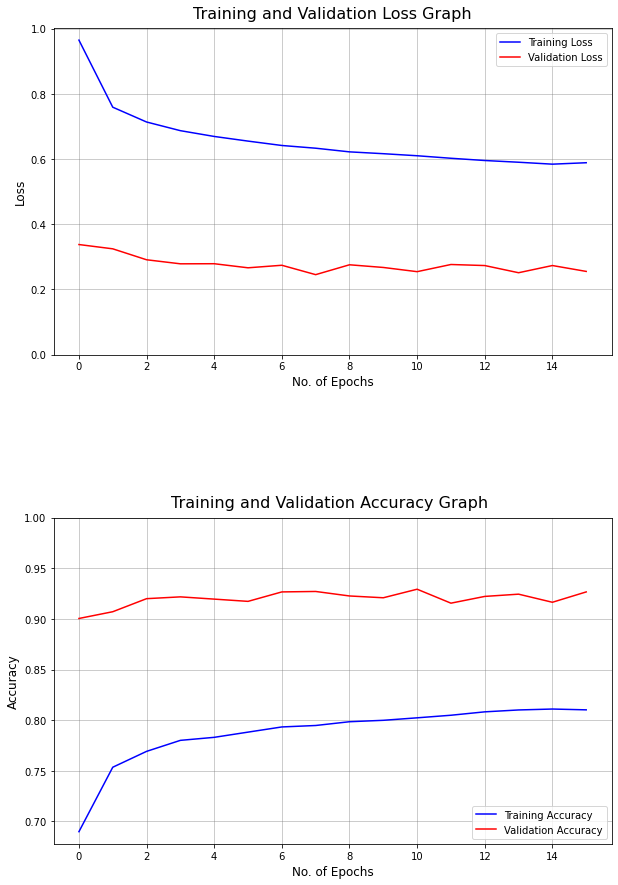

In [10]:
params = history["parameters"]
train_acc = history["accuracy"]
train_loss = history["loss"]
val_acc = history["val_accuracy"]
val_loss = history["val_loss"]
epochs = len(val_acc)


visualize_training_results(train_acc, val_acc, train_loss, val_loss)    

In [11]:
print("\n Epochs\t | Train Acc\t | Train Loss\t | Val Acc\t | Val Loss")
print("--------------------------------------------------------------------")
for i in range(epochs):
    print(" %d\t | %f\t | %f\t | %f\t | %f"%(i+1,train_acc[i] ,train_loss[i],val_acc[i] ,val_loss[i] ))


 Epochs	 | Train Acc	 | Train Loss	 | Val Acc	 | Val Loss
--------------------------------------------------------------------
 1	 | 0.689942	 | 0.964538	 | 0.900444	 | 0.337492
 2	 | 0.753570	 | 0.758788	 | 0.907111	 | 0.324354
 3	 | 0.769236	 | 0.713371	 | 0.920000	 | 0.290764
 4	 | 0.780107	 | 0.686784	 | 0.921778	 | 0.278361
 5	 | 0.783087	 | 0.669052	 | 0.919556	 | 0.278653
 6	 | 0.788233	 | 0.654781	 | 0.917333	 | 0.266143
 7	 | 0.793347	 | 0.641351	 | 0.926667	 | 0.273915
 8	 | 0.794777	 | 0.633001	 | 0.927111	 | 0.245126
 9	 | 0.798498	 | 0.621785	 | 0.922667	 | 0.275390
 10	 | 0.799902	 | 0.616157	 | 0.920889	 | 0.267181
 11	 | 0.802355	 | 0.609868	 | 0.929333	 | 0.254285
 12	 | 0.804901	 | 0.602152	 | 0.915556	 | 0.276263
 13	 | 0.808257	 | 0.595260	 | 0.922222	 | 0.273038
 14	 | 0.810120	 | 0.589959	 | 0.924444	 | 0.251015
 15	 | 0.811028	 | 0.584042	 | 0.916444	 | 0.273116
 16	 | 0.810230	 | 0.588427	 | 0.926667	 | 0.255054


### Evaluating test set

In [13]:
test_acc, test_loss = evaluate(test_x_norm,test_y_encoded,params)
print(test_acc, test_loss)

0.9284 0.24309707558061092


### Prediction

In [14]:
prediction_train = predict(train_x_norm, params, second_guess = True)
prediction_dev = predict(dev_x_norm,params, second_guess = True)
prediction_test = predict(test_x_norm, params, second_guess = True)

### Confusion Matrix

In [15]:
cm_train = confusion_matrix(train_y_split, prediction_train)
cm_dev = confusion_matrix(dev_y_split, prediction_dev)
cm_test = confusion_matrix(test_y_orig, prediction_test)

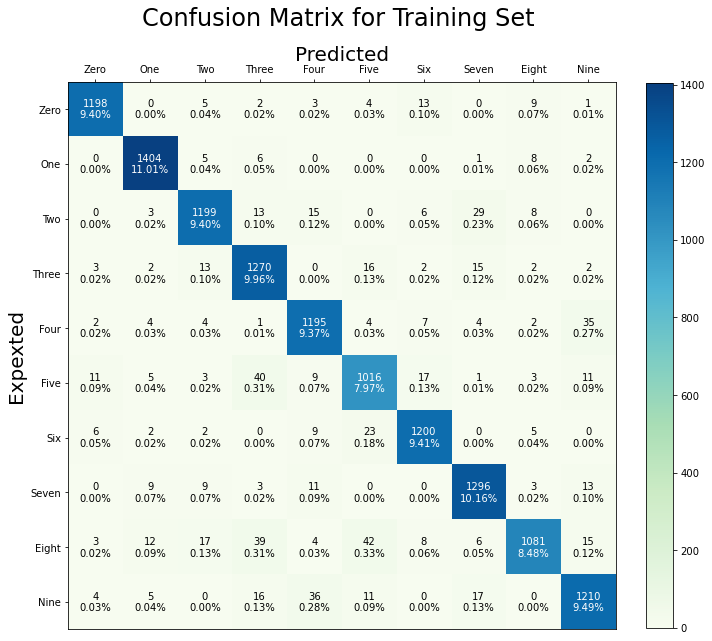

In [16]:
#plotting the confusion matrix   
plot_confusion_matrix(cm_train, dataset_type = "training")

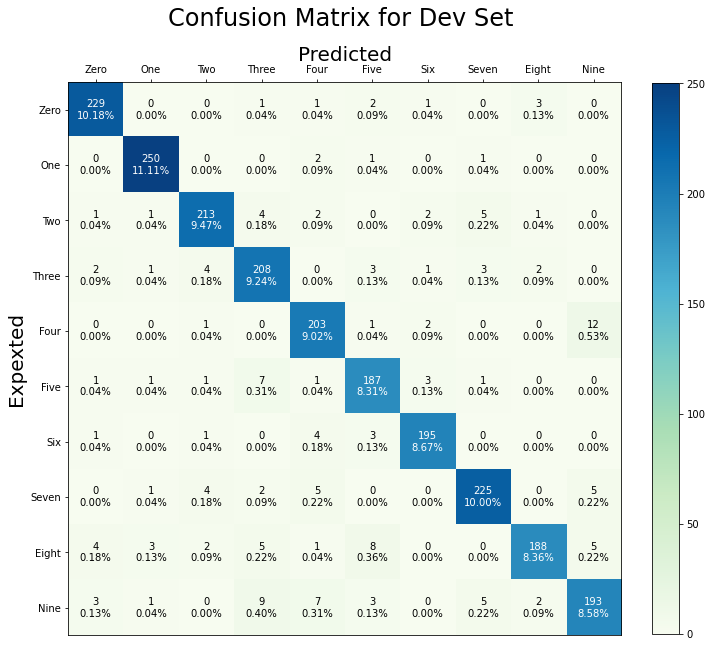

In [17]:
plot_confusion_matrix(cm_dev, dataset_type = "dev")

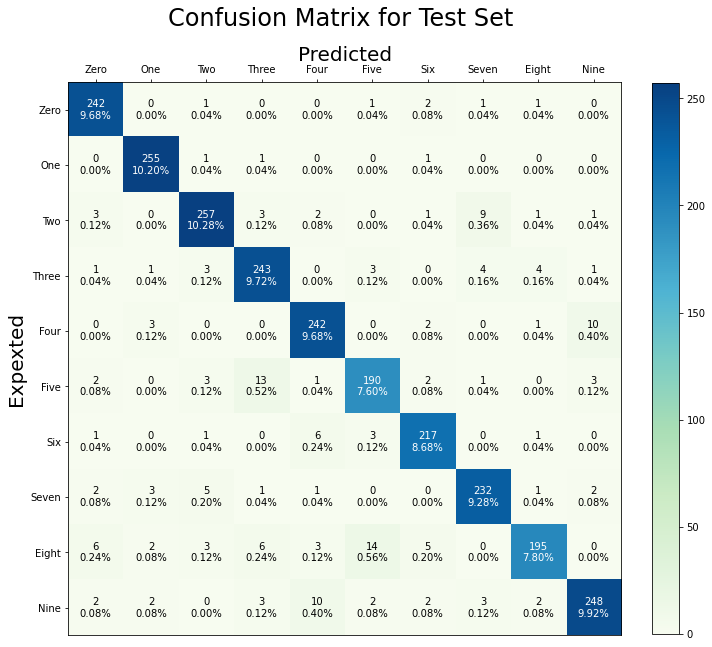

In [18]:
plot_confusion_matrix(cm_test, dataset_type = "test")

In [19]:
metrics, macro_metrics, acc = model_metrics(cm_train)
metric_summary(metrics, macro_metrics, acc)


+===============+===============+===============+===============+
| Label 	| Precision 	| Recall 	| F1 Score 	|
+===============+===============+===============+===============+
| 0 		|  0.97637 	|  0.97004 	|  0.97319 	|
| 1 		|  0.97095 	|  0.98457 	|  0.97772 	|
| 2 		|  0.95386 	|  0.94187 	|  0.94783 	|
| 3 		|  0.91367 	|  0.95849 	|  0.93554 	|
| 4 		|  0.93214 	|  0.94992 	|  0.94094 	|
| 5 		|  0.91039 	|  0.91039 	|  0.91039 	|
| 6 		|  0.95770 	|  0.96231 	|  0.96000 	|
| 7 		|  0.94668 	|  0.96429 	|  0.95540 	|
| 8 		|  0.96432 	|  0.88101 	|  0.92078 	|
| 9 		|  0.93871 	|  0.93149 	|  0.93509 	|
+===============+===============+===============+===============+
| Macro Avg 	|  0.94648 	|  0.94544 	|  0.94569 	|
+===============+===============+===============+===============+

 Accuracy 		  0.94659


In [20]:
metrics, macro_metrics, acc = model_metrics(cm_dev)
metric_summary(metrics, macro_metrics, acc)


+===============+===============+===============+===============+
| Label 	| Precision 	| Recall 	| F1 Score 	|
+===============+===============+===============+===============+
| 0 		|  0.95021 	|  0.96624 	|  0.95816 	|
| 1 		|  0.96899 	|  0.98425 	|  0.97656 	|
| 2 		|  0.94248 	|  0.93013 	|  0.93626 	|
| 3 		|  0.88136 	|  0.92857 	|  0.90435 	|
| 4 		|  0.89823 	|  0.92694 	|  0.91236 	|
| 5 		|  0.89904 	|  0.92574 	|  0.91220 	|
| 6 		|  0.95588 	|  0.95588 	|  0.95588 	|
| 7 		|  0.93750 	|  0.92975 	|  0.93361 	|
| 8 		|  0.95918 	|  0.87037 	|  0.91262 	|
| 9 		|  0.89767 	|  0.86547 	|  0.88128 	|
+===============+===============+===============+===============+
| Macro Avg 	|  0.92905 	|  0.92834 	|  0.92833 	|
+===============+===============+===============+===============+

 Accuracy 		  0.92933


In [21]:
metrics, macro_metrics, acc = model_metrics(cm_test)
metric_summary(metrics, macro_metrics, acc)


+===============+===============+===============+===============+
| Label 	| Precision 	| Recall 	| F1 Score 	|
+===============+===============+===============+===============+
| 0 		|  0.93436 	|  0.97581 	|  0.95464 	|
| 1 		|  0.95865 	|  0.98837 	|  0.97328 	|
| 2 		|  0.93796 	|  0.92780 	|  0.93285 	|
| 3 		|  0.90000 	|  0.93462 	|  0.91698 	|
| 4 		|  0.91321 	|  0.93798 	|  0.92543 	|
| 5 		|  0.89202 	|  0.88372 	|  0.88785 	|
| 6 		|  0.93534 	|  0.94760 	|  0.94143 	|
| 7 		|  0.92800 	|  0.93927 	|  0.93360 	|
| 8 		|  0.94660 	|  0.83333 	|  0.88636 	|
| 9 		|  0.93585 	|  0.90511 	|  0.92022 	|
+===============+===============+===============+===============+
| Macro Avg 	|  0.92820 	|  0.92736 	|  0.92726 	|
+===============+===============+===============+===============+

 Accuracy 		  0.92840


#### Visualizating  Prediction

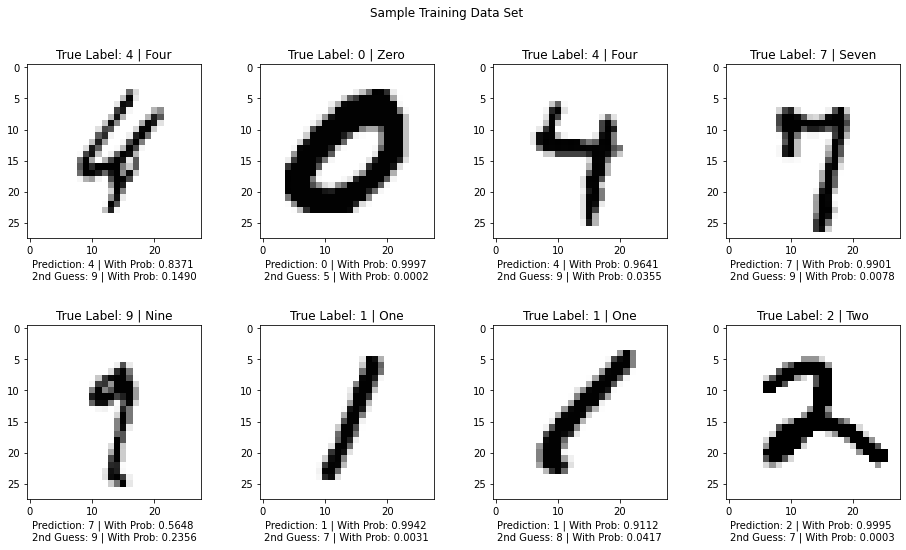

In [22]:
visualize_prediction(train_x_split, train_y_split.T, prediction_train, dataset_type = "training")

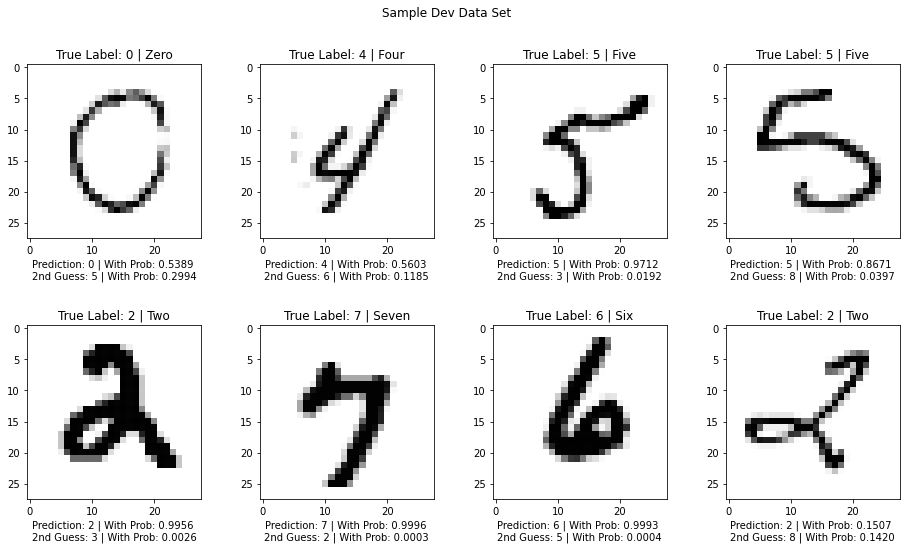

In [23]:
visualize_prediction(dev_x_split, dev_y_split.T, prediction_dev, dataset_type = "dev")

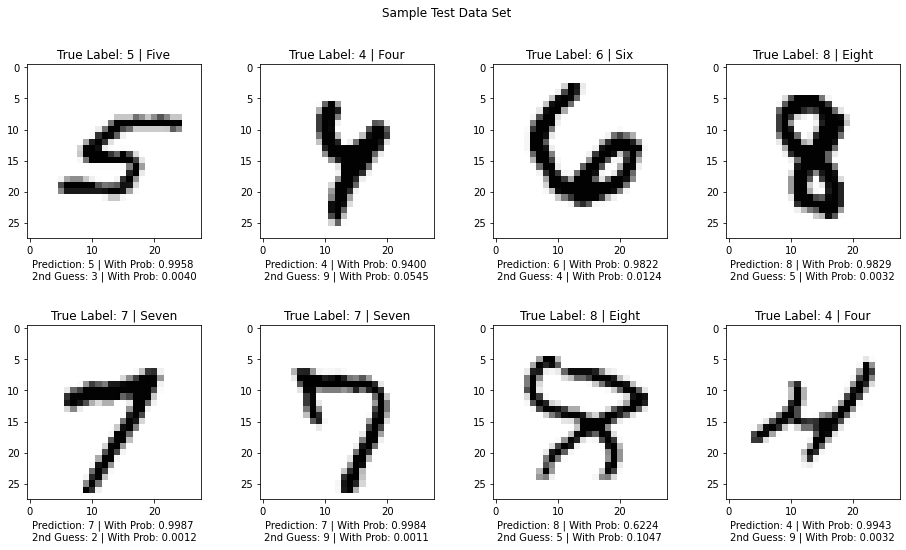

In [24]:
visualize_prediction(test_x_orig, test_y_orig.T, prediction_test,dataset_type = "test")

#### Visualizing Mislabelled Images in all datasets

Total Mislabelled Images: 681


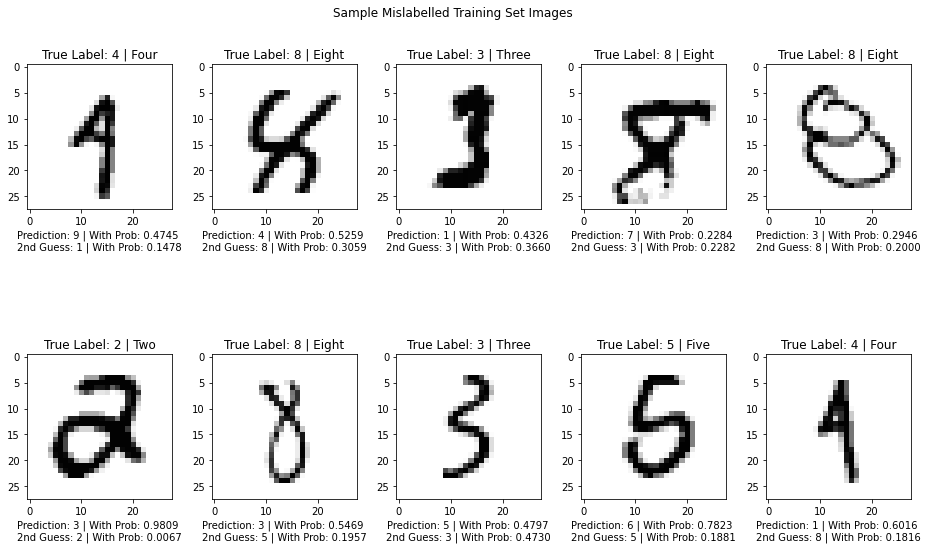

In [25]:
visualize_mislabelled_images(train_x_split, train_y_split.T,prediction_train,dataset_type = "training")

Total Mislabelled Images: 159


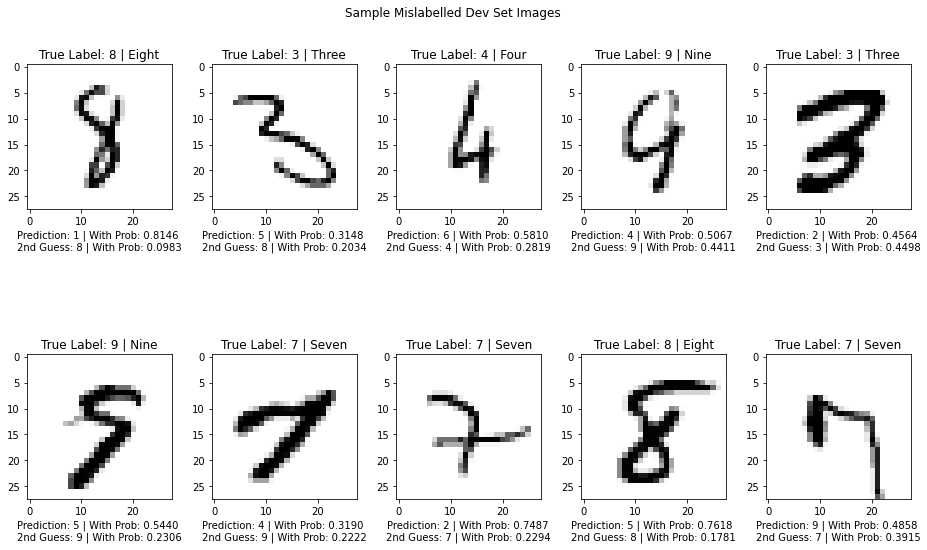

In [26]:
visualize_mislabelled_images(dev_x_split, dev_y_split.T, prediction_dev,dataset_type = "dev")

Total Mislabelled Images: 179


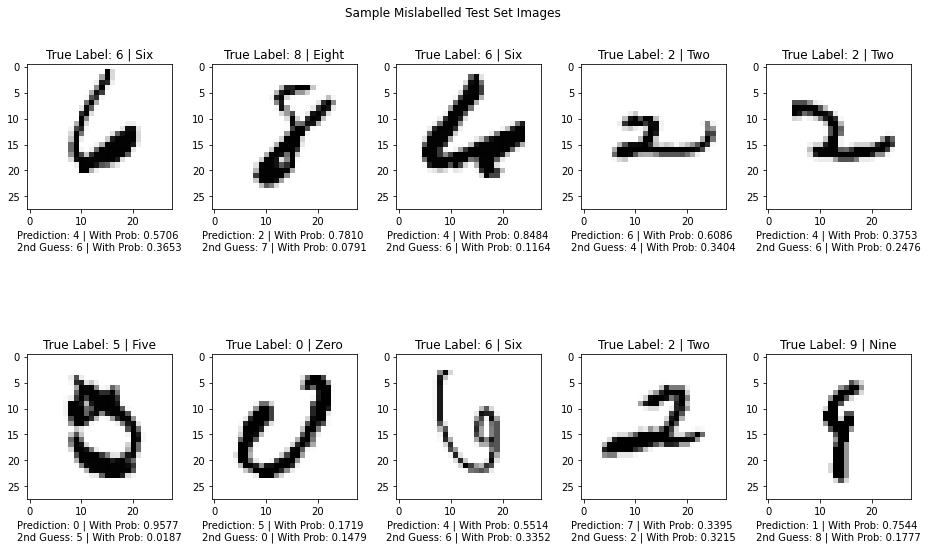

In [27]:
visualize_mislabelled_images(test_x_orig, test_y_orig.T, prediction_test,dataset_type = "test")

Total Mislabelled Images: 179


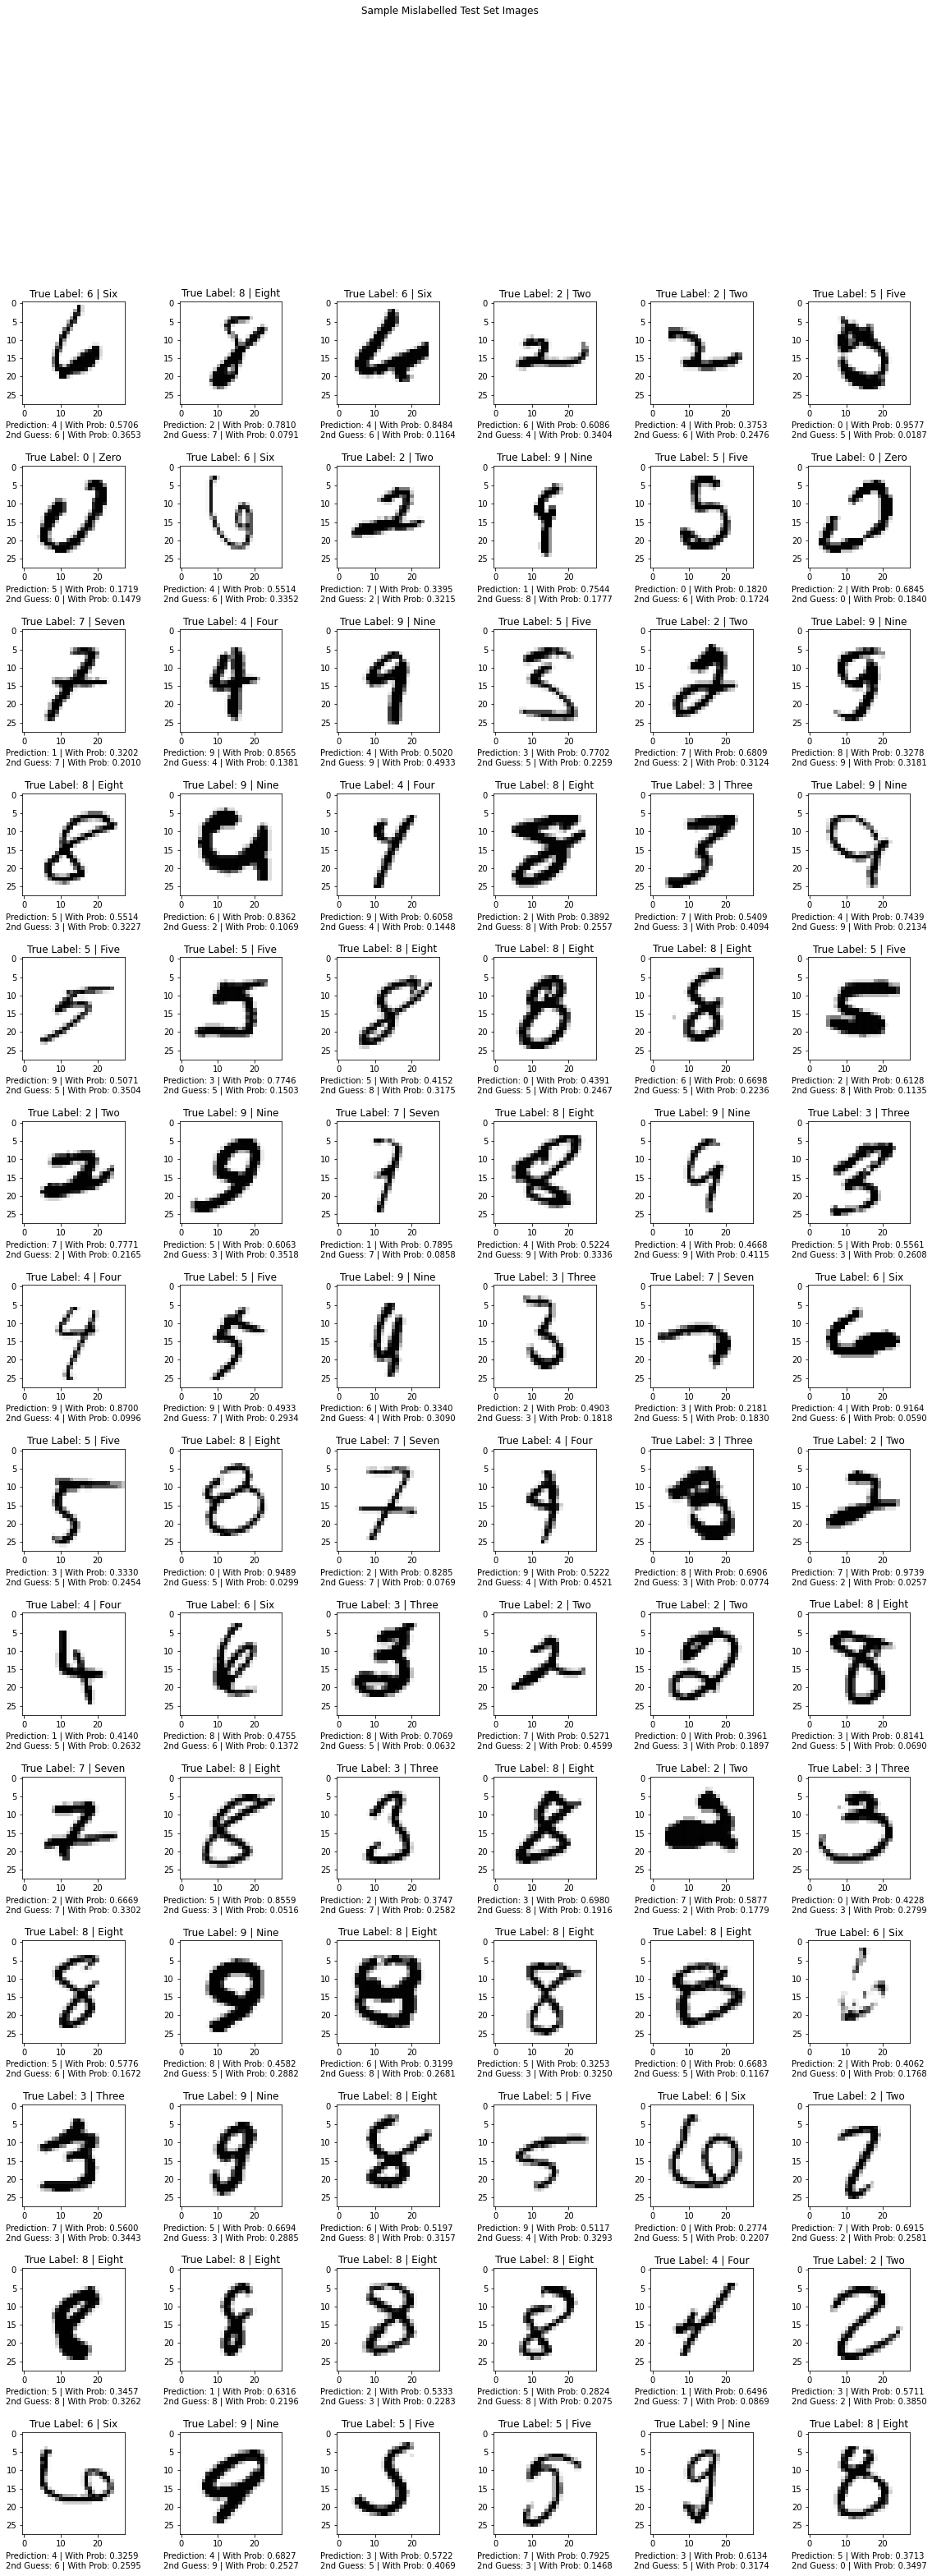

In [28]:
from dataset import label_description
first_lbl, first_prob = prediction_test["First Prediction"]
sec_lbl, sec_prob = prediction_test["Second Prediction"]
dataset_type = "test"
dataset="mnist"
true_prediction = np.equal(first_lbl, test_y_orig.T)
mislabelled_indices = np.asarray(np.where(true_prediction == False))
print("Total Mislabelled Images: " + str(len(mislabelled_indices[0])))

if (len(dataset_type) != 0):
    visual_title = "Sample Mislabelled %s Set Images " % dataset_type.capitalize()
else:
    raise ValueError("Dataset set must be training or dev or test set")

# getting the label description
label_desc = label_description(dataset)

# plotting the mislabelled images along with the predictions
fig, axes = plt.subplots(nrows=14, ncols=6, figsize=(20, 50))
fig.subplots_adjust(hspace=0.6)
fig.suptitle(visual_title)

for ax, i in zip(axes.flatten(), mislabelled_indices[1]):
    ax.imshow(test_x_orig[i].squeeze(), interpolation='nearest', cmap="Greys")
    ax.set(title="True Label: %d | %s" % (test_y_orig.T[0, i], label_desc[test_y_orig.T[0, i]]))
    ax.set(xlabel="Prediction: %d | With Prob: %.4f \n2nd Guess: %d | With Prob: %.4f" % (
    first_lbl[0, i], first_prob[0, i], sec_lbl[0, i], sec_prob[0, i]))

### Predicting Real Time images

In [29]:
from PIL import Image

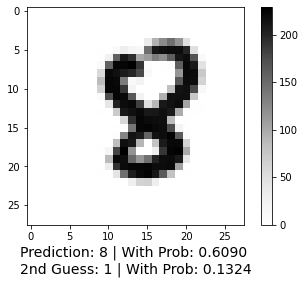

In [31]:
image_name = "8_1.jpg" 

fname = "Sample Images/" + image_name

image_data = np.asarray(Image.open(fname).convert('L').resize((28,28)))
if image_data[1,1] > 250: #if background is white, reversing the fore and background color to match training images
            image_data = 255 - image_data
def predict_real_time(image_data, second_guess = True):
    image_flattened = image_data.reshape(image_data.shape[0]*image_data.shape[1],-1)
    image_norm =(image_flattened/255.)

    prediction = predict(image_norm, params, second_guess = second_guess)
    
    return prediction
    
prediction = predict_real_time(image_data, second_guess = True)

first_lbl, first_prob = prediction["First Prediction"]
sec_lbl, sec_prob = prediction["Second Prediction"]

# plt.title("True Label: "+ str(label.squeeze()))
plt.xlabel("Prediction: %d | With Prob: %.4f \n2nd Guess: %d | With Prob: %.4f"%(first_lbl, first_prob, sec_lbl, sec_prob), fontsize = 14)
plt.imshow(image_data, interpolation ='nearest',cmap='Greys')
plt.colorbar()


## Saving and Loading model

In [ ]:

path = "Saved Models/"
fname = "custom_arch2_unscaled_online_Augmented_model_2M_test_acc_"+str(acc)

print(fname)

model = {"Parameters": params,
         "Activations": ["relu","softmax"],
## Save the following info if needed
         "Hyper Parameters": hyperParams,
         "initialization":"he",
         "regularizer":"dropout",
         "optimizer":"adam"
        }
save_model(file_name = path+fname, model = model)

In [ ]:
# loading model
path = "Saved Models/"

model = load_model(file_name =path+ "tuned_unscaled_online_Augmented_model_2M_test_acc_0.9916")

loaded_params = model["Parameters"]

In [ ]:
L = len(loaded_params) // 2
print("Total Layers %d: "%L)
for l in range(L):
    print(loaded_params["W" + str(l+1)].shape[0])


## To Do

- [x] Optimize and refactor the code
- [x] Prepare the doc String
- [x] add verbose: Integer. 0, 1, 2 or 3. Verbosity mode.
- [ ] Batch norm
- [ ] Maxout
- [ ] Drop Connect
- [x] Data Augmentation if possible

In [ ]:
!jupyter-nbconvert --to html 'Project Modules Evaluation with online data augmentation.ipynb' --output Experiments/custom2-unscaled-2M-data.html